In [37]:
import Pkg
Pkg.activate("MMLDS_project")

#SINDy
#Pkg.add("DataDrivenDiffEq")
#Pkg.add("DataDrivenSparse")
#Pkg.add("Subscripts")

#RESERVOIR 
#Pkg.update()
#Pkg.instantiate()
#Pkg.add("ProgressMeter")
#Pkg.add("DynamicalSystems")
#Pkg.add("ReservoirComputing")
#Pkg.add("Plots")
#Pkg.add("Printf")
#Pkg.add("DifferentialEquations")
#Pkg.add("OrdinaryDiffEq")
#Pkg.add("NetCDF")
#Pkg.add("JLD2")

#SINDy
using DataDrivenDiffEq
using DataDrivenSparse
using Subscripts #not working yet, took part of the code

#RESERVOIR
using ProgressMeter
using DynamicalSystems, ReservoirComputing, Plots, Printf
using DifferentialEquations
using OrdinaryDiffEq
using NetCDF
using JLD2

  Activating project at `c:\Users\tomfi\Desktop\Uni\3M_semester\Project_MMLDS\MMLDS_2\MMLDS_project\src\MMLDS_project`


In [39]:
#Loading and changing El Nino Data
path_to_data = "sst.mon.mean.nc"

x = ncread(path_to_data, "sst") #sst = Sea Surface Temperature
x_reduced = x[121:170, 86:95, :] #only concerned with the important region for the El Nino happening

X_vector = compress_data_matrix(x_reduced, 5, false, true)

20×2040 Matrix{Float64}:
 28.0325  27.8742  28.1076  28.688   …  28.621   29.4195  29.5172  29.0083
 28.2426  28.2316  28.488   28.9117     28.3489  29.3835  29.6865  29.3908
 28.5179  28.6131  28.8473  29.1355     28.6434  29.723   29.7411  29.3795
 28.84    28.8382  29.0742  29.1841     29.4347  30.2484  29.8994  29.4668
 29.023   28.9616  29.1702  29.2372     29.4146  30.2277  29.8914  29.5535
 29.1572  29.1256  29.2598  29.2776  …  29.7037  30.4001  30.031   29.7284
 29.1264  29.117   29.196   29.2381     29.8099  30.4189  30.0984  29.8489
 28.9993  29.0324  29.076   29.1209     30.1048  30.5088  30.2152  29.9283
 28.7191  28.7542  28.6979  28.8395     30.32    30.6631  30.3864  30.0508
 28.4407  28.3725  28.2181  28.6071     30.32    30.5643  30.4019  30.1978
 28.7257  28.5573  28.5916  28.9932  …  27.2255  28.4254  29.3495  29.8018
 28.7958  28.7403  28.7715  29.102      26.6425  28.0568  29.141   29.8132
 28.8938  28.9374  28.9322  29.1185     27.5829  28.7421  29.3249  29.7972


In [76]:
function create_basis(basis, dim, n)
    @variables t (x(t))[1:dim]

    if basis == "fourier_basis"
        basis = Basis(fourier_basis(x,n), x, iv=t)
    elseif basis == "sin_basis"
        basis = Basis(sin_basis(x,n), x, iv=t)
    elseif basis == "cos_basis"
        basis = Basis(cos_basis(x,n), x, iv=t)
    else
        basis = Basis(polynomial_basis(x, n), x, iv = t)
    end
    return basis
end

create_basis (generic function with 1 method)

In [121]:
include("data.jl")
include("SINDy.jl")

train_SINDy (generic function with 5 methods)

Model ##Basis#650 with 20 equations
States : 20
Parameters : 310
Independent variable: t
Equations
Difference(t; dt=1.0, update=false)((x(t))[1]) = p₁*sin((1//2)*(x(t))[1]) + p₁₀*sin((1//2)*(x(t))[18]) + p₁₂*sin((3//2)*(x(t))[1]) + p₂*sin((1//2)*(x(t))[2]) + p₁₃*sin((3//2)*(x(t))[2]) + p₁₈*cos((2//1)*(x(t))[2]) + p₃*sin((1//2)*(x(t))[8]) + p₄*sin((1//2)*(x(t))[10]) + p₅*sin((1//2)*(x(t))[11]) + p₁₄*sin((3//2)*(x(t))[4]) + p₁₅*sin((3//2)*(x(t))[8]) + p₁₆*sin((3//2)*(x(t))[13]) + p₁₇*sin((3//2)*(x(t))[16]) + p₆*sin((1//2)*(x(t))[13]) + p₇*sin((1//2)*(x(t))[14]) + p₈*sin((1//2)*(x(t))[15]) + p₉*sin((1//2)*(x(t))[17]) + p₁₁*cos((x(t))[3])
Difference(t; dt=1.0, update=false)((x(t))[2]) = p₁₉*sin((1//2)*(x(t))[1]) + p₂₀*sin((1//2)*(x(t))[2]) + p₂₇*sin((3//2)*(x(t))[2]) + p₂₁*sin((1//2)*(x(t))[8]) + p₃₂*cos((2//1)*(x(t))[2]) + p₂₂*sin((1//2)*(x(t))[10]) + p₂₃*sin((1//2)*(x(t))[11]) + p₂₄*sin((1//2)*(x(t))[13]) + p₂₅*sin((1//2)*(x(t))[15]) + p₂₆*sin((1//2)*(x(t))[18]) + p₂₈*sin((3//2)*(x(t))[6

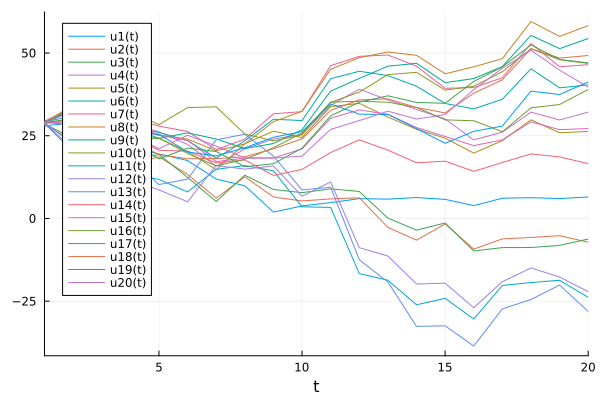

In [126]:
#shrink the dimensions to see if it is working
#we have to make more basis variables
x_sindy = X_vector[1:20,:]


ode_sol = create_data()


#lasso parameter lambda cannot be smaller than 1e-2, otherwise an error occurs
#ddsol = train_SINDy(ode_sol, 4 , 1e-1, 1e-1, n = 4)
ddsol = train_SINDy(x_sindy, 1e-1, 1e-1, basis = "fourier_basis",n = 4)
ddsol.prob.p[1]

function recovered_dynamics(u,p,t)
    return ddsol(u,p,t)
end

function create_SINDy_trajectory(x0 = [1.,1.,1.],dt = 1, tstart = 1., tend = 20.)

    p_SINDy = ddsol.prob.p
    tspan = (tstart, tend)
    saveat = tstart:dt:tend
    
    prob = ODEProblem(recovered_dynamics, x0, tspan, p_SINDy) 
    sol = solve(prob, Tsit5(), saveat=saveat)

    return sol
end
sol_sindy = create_SINDy_trajectory(X_vector[1:20,1])
plot(sol_sindy)

In [116]:
println(ode_sol isa Matrix)

false


In [64]:
#directely make use of the solution object:
#wrapper function
function recovered_dynamics(u,p,t)
    return ddsol(u,p,t)
end

function create_SINDy_trajectory(x0 = [1.,1.,1.],dt = 1, tstart = 1., tend = 100.)

    p_SINDy = ddsol.prob.p
    tspan = (tstart, tend)
    saveat = tstart:dt:tend
    x0 = X_vector[1:3,1]
    
    prob = ODEProblem(recovered_dynamics, x0, tspan, p_SINDy) 
    sol = solve(prob, Tsit5(), saveat=saveat)

    return sol
end



create_SINDy_trajectory (generic function with 5 methods)

In [45]:
function plot_SINDy_and_ElNino_trajectories(savePath, X_vector, sindy_sol)
    for i in 1:3
        i_data = X_vector[i, 1:100]
        p = plot(i_data, idxs=[1], tspan=(0, 100), label="El Nino Data", title="on real world data")
        p = plot!(sindy_sol[i,1:100], idxs=[1], tspan=(0, 100), label="SINDy")
        saveEnding = string(i)
        savePath_currently = savePath*"trajectory_" * string(saveEnding)*".png" 
        savefig(p, savePath_currently)
    end
end


plot_SINDy_and_ElNino_trajectories (generic function with 1 method)

In [46]:
sol = create_SINDy_trajectory()
#savePath = "/home/tom/Documents/GitHub/compare_ML_DynamicalSystem/MMLDS_project/Plots/SINDy/"
savePath = "C:/Users/tomfi/Desktop/Uni/3M_semester/Project_MMLDS/MMLDS_2/MMLDS_project/plots/"
plot_SINDy_and_ElNino_trajectories(savePath, X_vector, sol)

UndefVarError: UndefVarError: ddsol not defined

Some of the types have been truncated in the stacktrace for improved reading. To emit complete information
in the stack trace, evaluate `TruncatedStacktraces.VERBOSE[] = true` and re-run the code.
